***SAC** 算法原本是针对 **连续动作交互** 的环境提出的，首先在 **倒立摆环境** 下进行实验：*

导入相关库：

In [1]:
# 基本库
import numpy as np

from utils.replay_buffer import ReplayBuffer
from utils.training import train_off_policy_agent
from utils.smoothing import moving_average
# 神经网络
import torch
import torch.nn.functional as F

from torch.distributions import Normal
# Gymnasium 是一个用于开发和测试强化学习算法的工具库，为 OpenAI Gym 的更新版本（2021迁移开发）
import gymnasium as gym

### 定义策略网络和价值网络:

In [2]:
class PolicyNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound):
        super(PolicyNetContinuous, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc_mu = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_std = torch.nn.Linear(hidden_dim, action_dim)
        self.action_bound = action_bound

    def forward(self, x):
        x = F.relu(self.fc1(x))
        mu = self.fc_mu(x)
        std = F.softplus(self.fc_std(x))
        
        dist = Normal(mu, std)  # 构建高斯分布
        normal_sample = dist.rsample()  # rsample()是重参数化采样
        log_prob = dist.log_prob(normal_sample)
        # 动作范围映射
        action = torch.tanh(normal_sample)  # a=tanh(z) 
        action = action * self.action_bound
        # 概率密度的变量替换
        log_prob = log_prob - torch.log(1 - torch.tanh(action).pow(2) + 1e-7)  # 1-tanh(z)^2是tanh的导数（sech²），加1e-7避免log(0)
        return action, log_prob


class QValueNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(QValueNetContinuous, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x, a):
        cat = torch.cat([x, a], dim=1)
        x = F.relu(self.fc1(cat))
        x = F.relu(self.fc2(x))
        return self.fc_out(x)

##### 概率密度的变量替换
$$a=\tanh(z)$$
$$z=\operatorname{artanh}(a)=\frac{1}{2}\ln\frac{1+a}{1-a}$$
> 概率密度的变量替换公式:
$$p_A(a)=p_Z(z)\cdot\left|\frac{dz}{da}\right|$$
- $\frac{dz}{da}$ 其实就是 **雅可比行列式（Jacobian Determinant）** 的一维版本
> 又
$$\frac{dz}{da}=\frac{1}{1-a^2}=\frac{1}{1-\tanh(z)^2}=\frac{1}{\mathrm{sech}^2(z)}$$
> 所以
$$\log p_A(a)=\log p_Z(z)-\log\left(1-\tanh(z)^2\right + 1e-7)$$
- 加1e-7避免log(0)

### 定义 SAC 算法（连续动作）：

In [3]:
class SACContinuous:
    """ 处理连续动作空间 """
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound,
                 actor_lr, critic_lr, alpha_lr, target_entropy, tau, gamma,
                 device):
        self.actor = PolicyNetContinuous(state_dim, hidden_dim, action_dim, action_bound).to(device)  # 策略网络
        # 双Q网络
        self.critic_1 = QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device)  # 第一个Q网络
        self.critic_2 = QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device)  # 第二个Q网络
        self.target_critic_1 = QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device)  # 第一个目标Q网络
        self.target_critic_2 = QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device)  # 第二个目标Q网络
        # 令目标Q网络的初始参数和Q网络一样
        self.target_critic_1.load_state_dict(self.critic_1.state_dict())
        self.target_critic_2.load_state_dict(self.critic_2.state_dict())
        
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_1_optimizer = torch.optim.Adam(self.critic_1.parameters(), lr=critic_lr)
        self.critic_2_optimizer = torch.optim.Adam(self.critic_2.parameters(), lr=critic_lr)
        
        # 使用温度参数alpha的log值,可以确保 α 永远是正数,使训练结果比较稳定
        self.log_alpha = torch.tensor(np.log(0.01), dtype=torch.float)
        self.log_alpha.requires_grad = True  # 可以对alpha求梯度
        self.log_alpha_optimizer = torch.optim.Adam([self.log_alpha], lr=alpha_lr)
        
        self.target_entropy = target_entropy  # 目标熵的大小
        self.gamma = gamma
        self.tau = tau  # 软更新步长
        self.device = device

    def take_action(self, state):
        state = torch.tensor(np.array([state]), dtype=torch.float).to(self.device)
        action = self.actor(state)[0]
        return [action.item()]
    
    # 计算目标Q值
    def calc_target(self, rewards, next_states, dones):  # 计算目标Q值
        next_actions, log_prob = self.actor(next_states)
        entropy = -log_prob  # 连续动作熵用动作采样的负对数概率近似
        q1_value = self.target_critic_1(next_states, next_actions)
        q2_value = self.target_critic_2(next_states, next_actions)
        next_value = torch.min(q1_value,q2_value) + self.log_alpha.exp() * entropy
        td_target = rewards + self.gamma * next_value * (1 - dones)
        return td_target
    
    # DDPG中的软更新
    def soft_update(self, net, target_net):
        for param_target, param in zip(target_net.parameters(), net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) + param.data * self.tau)

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'], dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)


        # 更新两个Q网络
        td_target = self.calc_target(rewards, next_states, dones)
        critic_1_loss = torch.mean(F.mse_loss(self.critic_1(states, actions), td_target.detach()))
        critic_2_loss = torch.mean(F.mse_loss(self.critic_2(states, actions), td_target.detach()))
        self.critic_1_optimizer.zero_grad()
        critic_1_loss.backward()
        self.critic_1_optimizer.step()
        self.critic_2_optimizer.zero_grad()
        critic_2_loss.backward()
        self.critic_2_optimizer.step()

        # 更新策略网络
        new_actions, log_prob = self.actor(states)
        entropy = -log_prob  # 连续动作熵用动作采样的负对数概率近似
        q1_value = self.critic_1(states, new_actions)
        q2_value = self.critic_2(states, new_actions)
        actor_loss = torch.mean(-self.log_alpha.exp() * entropy - torch.min(q1_value, q2_value))
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # 更新alpha值
        alpha_loss = torch.mean((entropy - self.target_entropy).detach() * self.log_alpha.exp())
        self.log_alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.log_alpha_optimizer.step()

        # 软更新目标Q网络
        self.soft_update(self.critic_1, self.target_critic_1)
        self.soft_update(self.critic_2, self.target_critic_2)

### 环境设置（'Pendulum-v1'）：

In [4]:
np.random.seed(0)    # 设置 NumPy 的随机种子
torch.manual_seed(0) # 设置 PyTorch CPU 随机种子
torch.cuda.manual_seed_all(0) # 设置 PyTorch GPU 随机种子, 由于GPU并行性, 只能极大减小偏差

env_name = 'Pendulum-v1'
env = gym.make(env_name)
env.reset(seed=0)   # 环境通常依赖于其他随机数生成器来初始化状态、进行探索(推荐位于以上随机之后)
print("Environment spec:", env.spec)

Environment spec: EnvSpec(id='Pendulum-v1', entry_point='gymnasium.envs.classic_control.pendulum:PendulumEnv', reward_threshold=None, nondeterministic=False, max_episode_steps=200, order_enforce=True, disable_env_checker=False, kwargs={}, namespace=None, name='Pendulum', version=1, additional_wrappers=(), vector_entry_point=None)


### 超参数设置：

In [5]:
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]  # 连续动作空间
action_bound = env.action_space.high[0]  # 动作最大值
target_entropy = -env.action_space.shape[0] # 目标熵
hidden_dim = 128

actor_lr = 3e-4
critic_lr = 3e-3
alpha_lr = 3e-4
tau = 0.005  # 软更新参数
gamma = 0.99

device = torch.device("cuda") if torch.cuda.is_available() else torch.device( "cpu")

buffer_size = 100000
minimal_size = 1000
batch_size = 64
replay_buffer = ReplayBuffer(buffer_size)

agent = SACContinuous(state_dim, hidden_dim, action_dim, action_bound,
                      actor_lr, critic_lr, alpha_lr, target_entropy, tau,
                      gamma, device)

num_episodes = 100

### 测试与训练:

In [6]:
return_list = train_off_policy_agent(env, agent, num_episodes, replay_buffer, minimal_size, batch_size)

Iteration 9: 100%|██████████| 10/10 [00:38<00:00,  3.89s/it, episode=100, return=-181.239]


### 绘图：

In [7]:
import pandas as pd
episodes_list = list(range(len(return_list)))
mv_return = moving_average(return_list, 9)
# 创建 DataFrame
df1 = pd.DataFrame({'Episodes': episodes_list, 'Returns': return_list})
df2 = pd.DataFrame({'Episodes': episodes_list, 'Returns': mv_return})
# 保存为 CSV 文件
df1.to_csv('SAC_Pendulum-v1_returns_data.csv', index=False)
df2.to_csv('SAC_Pendulum-v1_mv_returns_data.csv', index=False)

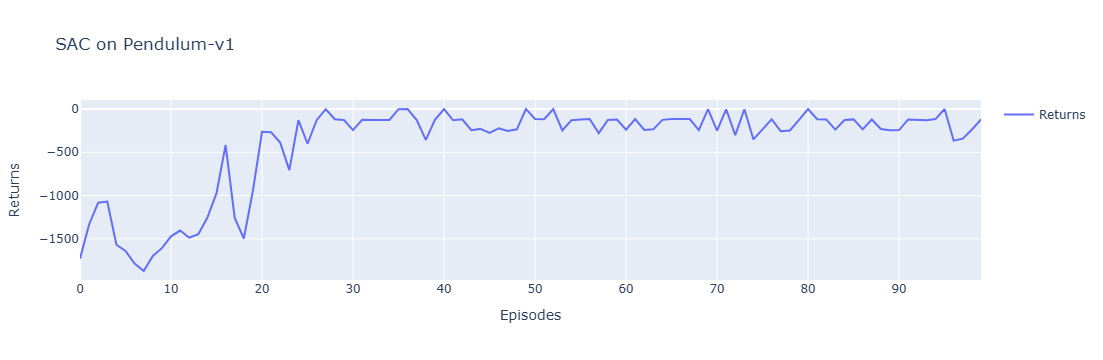

In [10]:
import plotly.graph_objects as go
import pandas as pd
df = pd.read_csv('SAC_Pendulum-v1_returns_data.csv')  # 从 CSV 文件中读取数据
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Episodes'], y=df['Returns'], mode='lines', name='Returns'))
fig.update_layout(
    title='SAC on Pendulum-v1',
    xaxis_title='Episodes',
    yaxis_title='Returns',
    showlegend=True
)
fig.show()

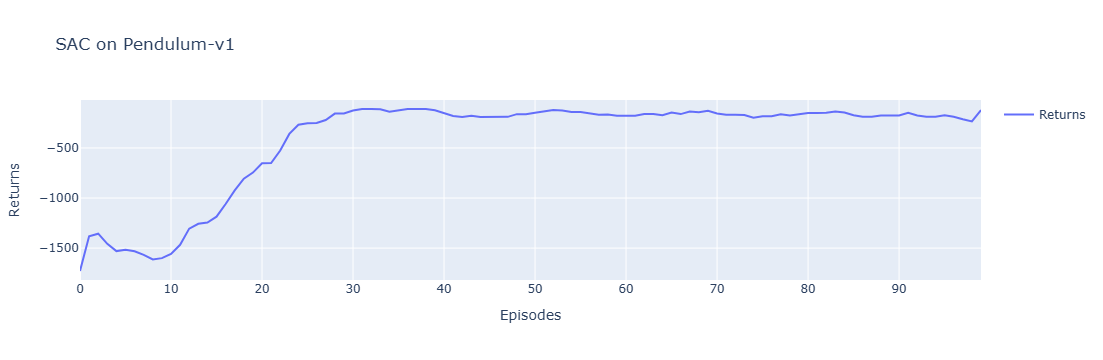

In [11]:
import plotly.graph_objects as go
import pandas as pd
df = pd.read_csv('SAC_Pendulum-v1_mv_returns_data.csv')  # 从 CSV 文件中读取数据
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Episodes'], y=df['Returns'], mode='lines', name='Returns'))
fig.update_layout(
    title='SAC on Pendulum-v1',
    xaxis_title='Episodes',
    yaxis_title='Returns',
    showlegend=True
)
fig.show()

*可以发现，**SAC** 在倒立摆环境中的表现非常出色：收敛快且稳定*